In [1]:
!pip install numpy torch pandas scikit-learn transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `panosk007` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticat

In [3]:

import json
import random
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
import matplotlib.pyplot as plt


with open("data/training_dataset.json", "r") as f:
    dataset = json.load(f)


dataset = [x for x in dataset if x["narratives"]]


all_labels = sorted(list({label for x in dataset for label in x["narratives"]}))
label_map = {label: i for i, label in enumerate(all_labels)}

X = [x["content"] for x in dataset]
y = [x["narratives"] for x in dataset]

# TF-IDF
tfidf = TfidfVectorizer().fit(X)
X_tfidf = tfidf.transform(X)

# Cosine similarity function
def fetch_most_similar_train_vectors(test_vector, train_vectors, k=3):
    similarities = cosine_similarity(test_vector.reshape(1, -1), train_vectors)
    most_similar_indices = np.argsort(similarities.flatten())[::-1][:k]
    return most_similar_indices

# Label mapping
def map_to_known_labels(raw_preds, all_labels):
    mapped = []
    for lbl in raw_preds:
        match = get_close_matches(lbl, all_labels, n=1, cutoff=0.7)
        if match:
            mapped.append(match[0])
    return mapped if mapped else ["Other"]

# Prompt generation
def get_prompt(test_text, shots):
    prompt = (
        "You are a narrative classification assistant.\n"
        "We classify narrative labels from texts, as in the following examples:\n"
    )
    for x, y in shots:
        lbls = ", ".join(y) if y else "Other"
        prompt += f"\"{x}\": {lbls}\n"
    prompt += f"\nThe valid labels are: {', '.join(all_labels)}.\n"
    prompt += (
        "Predict the correct label(s) for the following text, but generate only the label(s) and no other text.\n"
        "Please respond only with the correct label(s), comma-separated if more than one, and do not include any explanations.\n"
    )
    prompt += f"\n\"{test_text}\":"
    return prompt


llm = pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    max_new_tokens=256
)


def few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=3, mode="similar"):
    outputs = []
    for i, t_vec in tqdm(list(enumerate(X_test_tfidf))):
        if mode == "similar":
            shots_idxs = fetch_most_similar_train_vectors(t_vec, X_train_tfidf, k=n)
        else:
            shots_idxs = random.sample(range(len(X_train)), n)
        shots = [(X_train[j], y_train[j]) for j in shots_idxs]
        prompt = get_prompt(X_test[i], shots)
        response = llm(prompt)[0]["generated_text"]
        label_line = response.split(":")[-1].strip()
        raw_labels = [lbl.strip() for lbl in label_line.split(",")]
        predicted_labels = map_to_known_labels(raw_labels, all_labels)
        outputs.append(predicted_labels)
    return outputs


def binarize(y_data):
    bin_mat = []
    for row in y_data:
        row_vec = [0] * len(all_labels)
        for lbl in row:
            if lbl in label_map:
                row_vec[label_map[lbl]] = 1
        bin_mat.append(row_vec)
    return bin_mat


random.seed(42)
test_samples = random.sample(list(zip(X, y)), 100)
train_samples = [sample for sample in zip(X, y) if sample not in test_samples]

X_test, y_test = zip(*test_samples)
X_train, y_train = zip(*train_samples)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


results = {}
for shots in [0, 1, 3, 5, 10]:
    if shots == 0:
        predictions = []
        for text in tqdm(X_test):
            prompt = get_prompt(text, shots=[])  # zero-shot
            response = llm(prompt)[0]["generated_text"]
            label_line = response.split(":")[-1].strip()
            raw_labels = [lbl.strip() for lbl in label_line.split(",")]
            predicted_labels = map_to_known_labels(raw_labels, all_labels)
            predictions.append(predicted_labels)
    else:
        predictions = few_shot_learning_batch(X_test, X_test_tfidf, X_train, X_train_tfidf, y_train, n=shots, mode="similar")
    Y_true = binarize(y_test)
    Y_pred = binarize(predictions)
    acc = accuracy_score(Y_true, Y_pred)
    results[shots] = acc
    print(f"\n--- {shots}-shot Evaluation ---")
    print(classification_report(Y_true, Y_pred, target_names=all_labels, zero_division=0))
    print("Accuracy:", acc)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0
 10%|█         | 10/100 [01:49<16:14, 10.83s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 100/100 [17:51<00:00, 10.72s/it]



--- 0-shot Evaluation ---
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         1
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         6
                     CC: Criticism of climate movement       0.00      0.00      0.00        11
                     CC: Criticism of climate policies       0.17      0.08      0.11        12
         CC: Criticism of institutions and authorities       0.60      0.15      0.24        20
                        CC: Downplaying climate change       0.00      0.00      0.00         8
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         1
 CC: Hidden plots by secret schemes of powerful groups       0.33      0.17      0.22        12
          CC

100%|██████████| 100/100 [17:46<00:00, 10.66s/it]



--- 1-shot Evaluation ---
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         1
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         6
                     CC: Criticism of climate movement       1.00      0.09      0.17        11
                     CC: Criticism of climate policies       0.00      0.00      0.00        12
         CC: Criticism of institutions and authorities       0.50      0.10      0.17        20
                        CC: Downplaying climate change       0.00      0.00      0.00         8
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         1
 CC: Hidden plots by secret schemes of powerful groups       0.25      0.08      0.12        12
          CC

100%|██████████| 100/100 [17:53<00:00, 10.74s/it]



--- 3-shot Evaluation ---
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         1
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         6
                     CC: Criticism of climate movement       1.00      0.09      0.17        11
                     CC: Criticism of climate policies       0.67      0.17      0.27        12
         CC: Criticism of institutions and authorities       0.50      0.05      0.09        20
                        CC: Downplaying climate change       0.00      0.00      0.00         8
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         1
 CC: Hidden plots by secret schemes of powerful groups       0.50      0.08      0.14        12
          CC

100%|██████████| 100/100 [18:14<00:00, 10.94s/it]



--- 5-shot Evaluation ---
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         1
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         6
                     CC: Criticism of climate movement       0.50      0.18      0.27        11
                     CC: Criticism of climate policies       0.00      0.00      0.00        12
         CC: Criticism of institutions and authorities       0.00      0.00      0.00        20
                        CC: Downplaying climate change       0.00      0.00      0.00         8
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         1
 CC: Hidden plots by secret schemes of powerful groups       0.40      0.17      0.24        12
          CC

100%|██████████| 100/100 [18:43<00:00, 11.24s/it]


--- 10-shot Evaluation ---
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.00      0.00      0.00         1
                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         6
                     CC: Criticism of climate movement       1.00      0.18      0.31        11
                     CC: Criticism of climate policies       0.00      0.00      0.00        12
         CC: Criticism of institutions and authorities       0.00      0.00      0.00        20
                        CC: Downplaying climate change       0.00      0.00      0.00         8
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         1
 CC: Hidden plots by secret schemes of powerful groups       0.33      0.08      0.13        12
          C

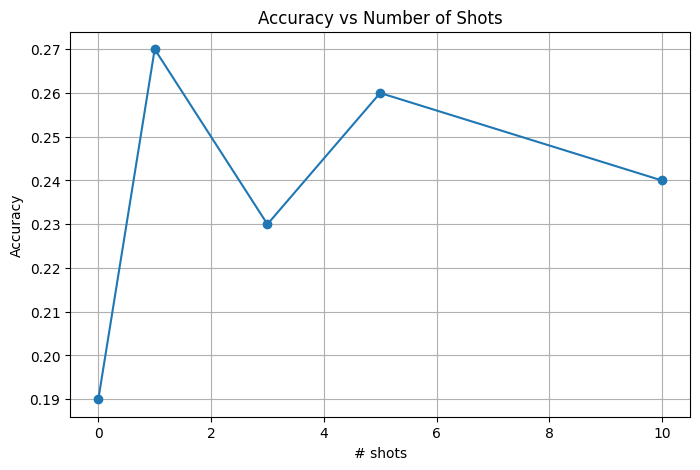

In [4]:

plt.figure(figsize=(8, 5))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title("Accuracy vs Number of Shots")
plt.xlabel("# shots")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("accuracy_vs_shots.png")
plt.show()


In [1]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
  --ClearOutputPreprocessor.enabled=True \
  --to notebook --inplace k_shots_eval_similar.ipynb

[NbConvertApp] Converting notebook k_shots_eval_similar.ipynb to notebook
[NbConvertApp] Writing 7157 bytes to k_shots_eval_similar.ipynb
